## Import libraries, read csv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import xgboost
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint, uniform

from sklearn import metrics

In [ ]:
loan = pd.read_csv("data/loan.csv", parse_dates=['applicationDate','originatedDate']) # 2016-02-23T17:29:01.940000 --> 2016-02-23 17:29:01.940
paym = pd.read_csv("data/payment.csv", parse_dates=["paymentDate"])
cla_undwri_var = pd.read_csv("data/clarity_underwriting_variables.csv")
#cla_undwri_dict = pd.read_csv("dictionaries/clarity_underwriting_dictionary.csv")

#Additional data
usnews_best_state = pd.read_csv("data/usnews best states ranking 2017.csv")
google_geo = pd.read_csv("data/google latitude longtitude.csv")

print(loan.shape, paym.shape, cla_undwri_var.shape)
print(loan.duplicated().sum(), paym.duplicated().sum(), cla_undwri_var.duplicated().sum()) #Check whether there are duplicated rows

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(577682, 19) (689364, 9) (49752, 54)
0 0 0


## Understanding Data: Hierarchy of person, underwriting report, loan, payment

* Each person has 0 ~ 9 underwriting reports.
* Each person has 1 ~ 35 loans.
* Each underwriting report can be used for 1 ~ 15 loans.
* Each loan takes 3 ~ 105 payments to pay off.

In [ ]:
def check_unique(loan, paym, cla_undwri_var):
  """Check uniqueness of merge point"""
  print("loan['loanId'] ",loan.loc[:,"loanId"].nunique(),"/", loan.shape[0]," unique | paym['loanId'] ",paym.loc[:,"loanId"].nunique(),"/", paym.shape[0], " unique")
  print("loan['clarityFraudId'] ",loan.loc[:,"clarityFraudId"].nunique(),"/", loan.shape[0]," unique | cla_undwri_var['underwritingid'] ",cla_undwri_var.loc[:,"underwritingid"].nunique(),"/", cla_undwri_var.shape[0], " unique")

check_unique(loan, paym, cla_undwri_var)

loan['loanId']  577426 / 577682  unique | paym['loanId']  39952 / 689364  unique
loan['clarityFraudId']  314915 / 577682  unique | cla_undwri_var['underwritingid']  49752 / 49752  unique


In [ ]:
loan_ = loan.copy().dropna(subset=["loanId"])
paym_ = paym.copy().dropna(subset=["loanId"])

cfid_per_anon = loan_.groupby("anon_ssn")["clarityFraudId"].nunique()
loanid_per_anon = loan_.groupby("anon_ssn")["loanId"].nunique()
loanid_per_cfid = loan_.groupby("clarityFraudId")["loanId"].nunique()
paym_per_loanid = paym_.loc[paym.loc[:,"loanId"].isin(loan_.loc[:,"loanId"])].groupby("loanId").agg("count").loc[:,"paymentDate"]

print("Each person has", cfid_per_anon.min(),"~", cfid_per_anon.max(), "underwriting reports.")
print("Each person has", loanid_per_anon.min(),"~", loanid_per_anon.max(), "loans.")
print("Each underwriting report can be used for",loanid_per_cfid.min(),"~", loanid_per_cfid.max(), "loans.")
print("Each loan takes",paym_per_loanid.min(),"~", paym_per_loanid.max(), "payments to pay off.")

Each person has 0 ~ 9 underwriting reports.
Each person has 1 ~ 35 loans.
Each underwriting report can be used for 1 ~ 15 loans.
Each loan takes 3 ~ 105 payments to pay off.


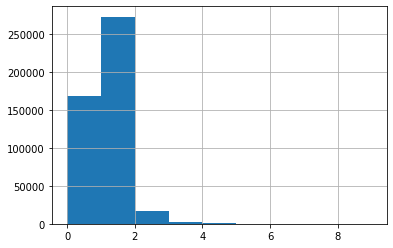

In [ ]:
cfid_per_anon.hist(bins=cfid_per_anon.max()-cfid_per_anon.min())

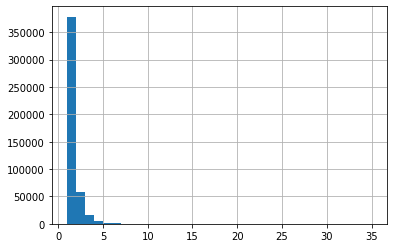

In [ ]:
loanid_per_anon.hist(bins=loanid_per_anon.max()-loanid_per_anon.min())

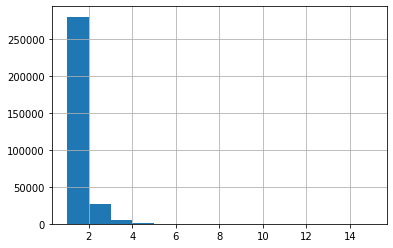

In [ ]:
loanid_per_cfid.hist(bins=loanid_per_cfid.max()-loanid_per_cfid.min())

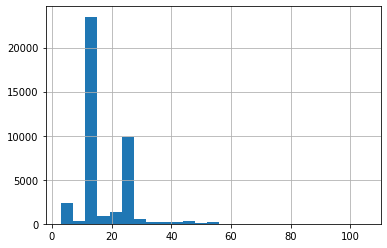

In [ ]:
paym_per_loanid.hist(bins=(paym_per_loanid.max()-paym_per_loanid.min())//4)

## Check Merge Points: Missing Values + Uniqueness of IDs
#### loan.csv:
* ~38% of loan["clarityFraudId"] are NaNs
* refer "Analyze Target Variable (loanStatus)"

#### payment.csv
* refer "Feature Engineering on payment.csv"

#### clarity_underwriting_variables.csv:
* Contains	variables	returned	from	a	data	provider	that	is	used	to	underwrite	loans
* Each	row	represents	an	underwriting	report
* Not	all	rows	in	loan.csv	has	a	corresponding	row	in clarity_underwriting_variables.csv
* refer "Remove features with too many missing values in clarity_underwriting_variables.csv"




In [ ]:
print(loan.shape, paym.shape, cla_undwri_var.shape)
loan = loan.dropna(subset=["loanId", "clarityFraudId"])
paym = paym.dropna(subset=["loanId"])
cla_undwri_var = cla_undwri_var.dropna(subset=["underwritingid"])
print(loan.shape, paym.shape, cla_undwri_var.shape)

(577682, 19) (689364, 9) (49752, 54)
(357588, 19) (689364, 9) (49752, 54)


In [ ]:
check_unique(loan, paym, cla_undwri_var)

loan['loanId']  357588 / 357588  unique | paym['loanId']  39952 / 689364  unique
loan['clarityFraudId']  314864 / 357588  unique | cla_undwri_var['underwritingid']  49752 / 49752  unique


## Feature Engineering on payment.csv

In [ ]:
#Convert datetime to number of days (Part1: for payment.csv)
date = "paymentDate"
appDate_min = loan.loc[:,"applicationDate"].min() #the very beginning #in Timestamp format
paym.loc[:,date+"_days"] = (paym.loc[:,date]-appDate_min).dt.days

In [ ]:
paym_means = paym.groupby("loanId")["paymentDate_days","principal","fees"].agg("mean") #why fees larger than principal?

paym_payStat = paym.groupby("loanId")["paymentStatus"].agg(lambda x : x=="Checked") # loanId, [True, False, ...]
paym_payStat = paym_payStat.apply(sum) # how many True
paym_payStat_ct = paym.groupby("loanId")["paymentStatus"].agg("count")

paym_isCo = paym.groupby("loanId")["isCollection"].agg(lambda x : list(x==True))
paym_isCo = paym_isCo.apply(sum)
paym_isCo_ct = paym.groupby("loanId")["isCollection"].agg("count")

paym_feats = paym_means
paym_feats.loc[:,"payStat_Checked_perct"] = paym_payStat / paym_payStat_ct
paym_feats.loc[:,"isCo_perct"] = paym_isCo / paym_isCo_ct

paym_feats.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,paymentDate_days,principal,fees,payStat_Checked_perct,isCo_perct
loanId,,,,,
LL-I-00000021,124.307692,61.539231,95.016154,0.923077,0.076923
LL-I-00000231,96.050000,75.123500,94.827500,0.100000,0.000000
LL-I-00000238,102.000000,79.098750,91.692500,0.437500,0.000000
LL-I-00000308,118.227273,17.805455,43.784545,0.045455,0.000000
LL-I-00000355,87.260870,43.478261,63.109565,0.000000,0.000000


(689364, 10)
(573812, 10)


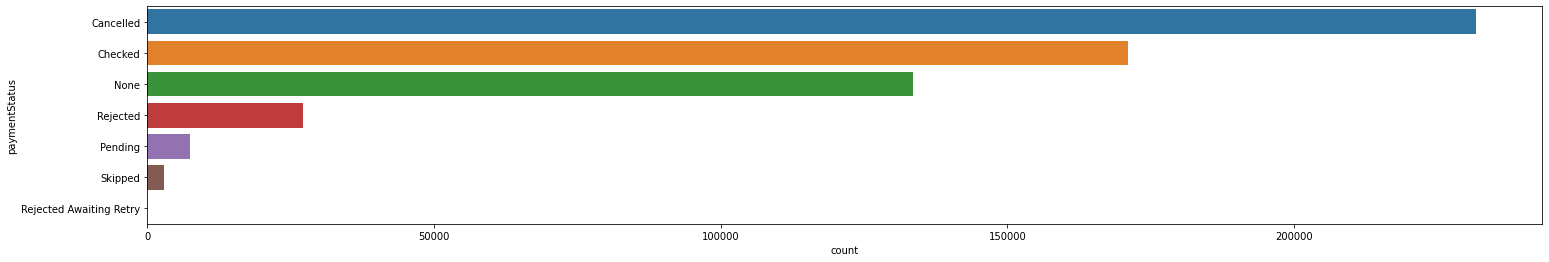

In [ ]:
print(paym.shape)
paym = paym.loc[paym.loc[:,"loanId"].isin(loan.loc[:,"loanId"])] # ~17% dont have corresponding loanId in loan.csv, remove them
print(paym.shape)
plt.figure(figsize=(25, 4))
sns.countplot(y=paym.loc[:,"paymentStatus"], order=paym.loc[:,"paymentStatus"].value_counts().index) 

## Embedding for states 

refer "Avoid One-Hot Encoding for Categorical Attributes"

[1] https://www.usnews.com/media/best-states/overall-rankings-2017.pdf

[2] https://developers.google.com/public-data/docs/canonical/states_csv

Total of 50 + 2 states (peurto rico, district of columbia), we only have 40 states in loan.csv


In [ ]:
state_feats = pd.merge(usnews_best_state, google_geo, left_on="State", right_on="name", how="left").drop(columns=["State","name"])
state_feats.head(5)

,Overall Rank,Health Care,Education,Crime & Corrections,Infrastructure,Opportunity,Economy,Government,state,latitude,longitude
0,1,2,1,7,19,16,5,16,MA,42.407211,-71.382437
1,2,4,3,12,13,1,13,30,NH,43.193852,-71.572395
2,3,3,11,17,5,2,12,24,MN,46.729553,-94.685900
3,4,19,16,15,6,7,2,7,ND,47.551493,-101.002012
4,5,9,7,25,2,17,11,8,WA,47.751074,-120.740139


## Analyze Target Variable (loanStatus)

Here we define the positive (good loan) as loans which return is positive, i.e. by issuing this loan, not only is the lender able to collect the initial principal, but interest can also be earned alongside. Any other loan outcome that does not satisfy this citeria is defined as negative (bad loan), which return is negative. A negative-return loan might be in the form of a settlement, when the borrower regotiates to pay less than the full amount[3]. Alternatively, the account might be charged off (taken as financial loss) and the debt is sold to a collection agency, internal or external[4]. The worst case scenario happens when the borrower declares bankruptcy, in which case the lender loses all the amount lended.

Choose:

* Positive: "Paid Off Loan", "Returned Item"

* Negative: "External Collection", "Internal Collection", "Settlement Paid Off", "Settled Bankruptcy", "Charged Off Paid Off"

The others are either ongoing or not ultimately funded (void)

[3] https://loansettlement.com/

[4] https://www.forbes.com/advisor/debt-relief/debt-charged-off-as-bad-debt/#:~:text=It%20means%20the%20debt%20has,transferred%20to%20a%20collection%20agency.



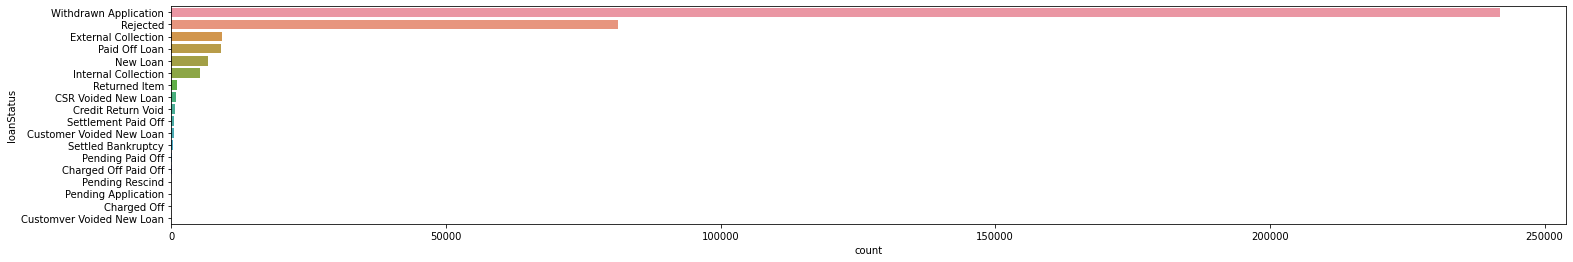

In [ ]:
plt.figure(figsize=(25, 4))
sns.countplot(y=loan.loc[:,"loanStatus"], order=loan.loc[:,"loanStatus"].value_counts().index) 

In [ ]:
print(loan.shape)
loan = loan.loc[loan.loc[:,"loanStatus"].isin(["Paid Off Loan", "Returned Item",
                                               "External Collection", "Internal Collection", "Settlement Paid Off", "Settled Bankruptcy", "Charged Off Paid Off"])] 
print(loan.shape) 
loan = loan.loc[loan.loc[:,"isFunded"]==True] #ultimately funded, which should all be true (given loanStatus), so there's probably some wrong info in these 5 rows
print(loan.shape)

(357588, 19)
(25589, 19)
(25584, 19)


In [ ]:
x = loan.isna().sum() #clean remaining missing values
x[x>0]

nPaidOff    2
fpStatus    5
dtype: int64

In [ ]:
del x
loan = loan.dropna(subset=["nPaidOff","fpStatus"]) 
loan.head(5)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1
64,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,Paid Off Loan,300.0,422.64,WI,organic,0,Checked,56621584e4b0100e84141586,1
83,LL-I-18297678,bc500677542783c43842d54e34830f08,B,315.0,2017-03-12 18:24:46.356,True,2017-03-12 19:00:23.818,2.0,True,1,Internal Collection,1500.0,2875.27,IL,organic,0,Rejected,579101e7e4b0810ad80e43aa,1


In [ ]:
check_unique(loan, paym, cla_undwri_var)

loan['loanId']  25577 / 25577  unique | paym['loanId']  33254 / 573812  unique
loan['clarityFraudId']  24192 / 25577  unique | cla_undwri_var['underwritingid']  49752 / 49752  unique


## Merge DataFrames (to loan.csv)

In [ ]:
print(loan.shape)
loan = pd.merge(loan, cla_undwri_var, left_on="clarityFraudId", right_on="underwritingid", how="left")
print(loan.shape)
loan = pd.merge(loan, paym_feats, how="left", on="loanId")
print(loan.shape)
loan = pd.merge(loan, state_feats, how="left", on="state")
print(loan.shape)

(25577, 19)
(25577, 73)
(25577, 78)
(25577, 88)


## Remove features with too many missing values in clarity_underwriting_variables.csv

In [ ]:
nan_perct = loan.isna().sum()*100/loan.shape[0]
nan_perct.sort_values(ascending=False).head(15)

.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype                           96.711890
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode                   94.706181
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription        94.706181
.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode               88.962740
.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription    88.962740
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode                    81.588928
.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile            80.369082
.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone           42.968292
.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone    

In [ ]:
#drop columns that have too many NaNs
nan_col_lst = nan_perct.loc[nan_perct > 1].index.to_list()
print(loan.shape)
loan = loan.drop(columns=nan_col_lst)
print(loan.shape) 

(25577, 88)
(25577, 75)


## Feature Selection

Types of features in loan.csv:

* Categorical: payFrequency, loanStatus, state, Lead	type, fpStatus

* Datetime: applicationDate, originatedDate

* Bool: originated, approved, isFunded

* Value: apr, nPaidOff, loanAmount, originallyScheduledPaymentAmount,  Lead	cost

* ID: loanId, anon_ssn, clarityFraudId

Errors in loan.csv:

* isFunded and hasCF (clarity fraud) is 0 / 1 instead of Boolean string

* originallyScheduledPaymentAmount has negative values

* states have "OH-TEST" and "TX-TEST"

In [ ]:
#Check the range of dates 
print(appDate_min)
print(loan.loc[:,'applicationDate'].min()) 
print(loan.loc[:,'applicationDate'].max())

#Convert datetime to number of days (Part2: for loan.csv)
for date in ["applicationDate","originatedDate"]:
  loan.loc[:,date+"_days"] = (loan.loc[:,date]-appDate_min).dt.days

2014-12-03 15:36:04.144000
2015-01-31 00:10:21.133000
2017-03-18 23:38:50.917000


In [ ]:
#Inspect numerical attributes
"""
col_lst = list(loan.select_dtypes(include=["float64","int64"]).columns)
for col in col_lst:
  #col = list(loan.select_dtypes(include=["object"]).columns)[0]
  print(col, loan.loc[:,col].min())
  plt.figure(figsize=(20, 4))
  sns.histplot(y=loan.loc[:,col]) 
  plt.show()
"""

'\ncol_lst = list(loan.select_dtypes(include=["float64","int64"]).columns)\nfor col in col_lst:\n  #col = list(loan.select_dtypes(include=["object"]).columns)[0]\n  print(col, loan.loc[:,col].min())\n  plt.figure(figsize=(20, 4))\n  sns.histplot(y=loan.loc[:,col]) \n  plt.show()\n'

In [ ]:
#Inspect categorical attributes
"""
col_lst = list(set(loan.select_dtypes(include=["object"]).columns) - set(["loanId", "anon_ssn", "clarityFraudId", "underwritingid"]))
for col in col_lst:
  #col = list(loan.select_dtypes(include=["object"]).columns)[0]
  print(col)
  plt.figure(figsize=(20, 4))
  sns.countplot(y=loan.loc[:,col], order=loan.loc[:,col].value_counts().index) 
  plt.show()
#https://stackoverflow.com/questions/46623583/seaborn-countplot-order-categories-by-count
#plt.xticks(rotation=-90)
"""

'\ncol_lst = list(set(loan.select_dtypes(include=["object"]).columns) - set(["loanId", "anon_ssn", "clarityFraudId", "underwritingid"]))\nfor col in col_lst:\n  #col = list(loan.select_dtypes(include=["object"]).columns)[0]\n  print(col)\n  plt.figure(figsize=(20, 4))\n  sns.countplot(y=loan.loc[:,col], order=loan.loc[:,col].value_counts().index) \n  plt.show()\n#https://stackoverflow.com/questions/46623583/seaborn-countplot-order-categories-by-count\n#plt.xticks(rotation=-90)\n'

In [ ]:
#drop columns in clarity_underwriting_variables.csv that have one dominating category over the others (e.g. many False compared to True)
print(loan.shape)
loan = loan.drop(columns=["loanId", "anon_ssn", "clarityFraudId", "underwritingid", "isFunded", "hasCF",
                          "applicationDate", "originated", "originatedDate", "approved", "state",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18",
                          ".underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother",])
print(loan.shape)

(25577, 77)
(25577, 46)


## Avoid One-Hot Encoding for Categorical Attributes
One-hot encoding categorical attributes with a large number of possible categories will result in a large number of input features, leading to a large but sparse input dataset, which will slow down training. Plus, the introduced features are dummy variables that don't carry any information about the category. Therefore, a more informed approach would be to use numerical features that can characterize the category. 

In [ ]:
def convert_bool_nan_to_int(x):
  if x == True:
    ret = 1
  elif x == False:
    ret = 0
  elif math.isnan(x):
    ret = float('nan')
  else:
    print("[Warning] not bool or nan !!!")
  return ret

def convert_match_to_one(x):
  if x=="match":
    ret = 1
  elif not isinstance(x,str):
    if math.isnan(x):
      ret = x
  else:
    ret = 0
  return ret

def convert_payfreq_to_weeks(x):
  #https://www.zoho.com/people/hrknowledgehive/Bi-weekly-vs-Semi-monthly-pay-periods-Differences-and-benefits.html
  payfreq_to_int_dict = {'W':1, 'S':52/24, 'B':52/26, 'M':4, 'I':5} #52/26=2
  ret = payfreq_to_int_dict[x]
  if not isinstance(x,str):
    if math.isnan(x):
      ret = x
  return ret

def fpstatus_to_int(x):
  if x=="Checked":
    ret = 1
  elif not isinstance(x,str):
    if math.isnan(x):
      ret = x
  else:
    ret = 0
  return ret

def loanstatus_to_targetvar(x):
  if x in ["Paid Off Loan", "Returned Item",]:
    ret = 1
  elif x in ["External Collection", "Internal Collection", "Settlement Paid Off", "Settled Bankruptcy", "Charged Off Paid Off"]:
    ret = 0
  return ret

loan_ = loan.copy()
col_lst = list(loan_.select_dtypes(include=["object"]).columns)
for col in col_lst:
  if loan_.loc[:,col].isin([True,False]).any():
    print(col)
    loan_.loc[:,col] = loan_.loc[:,col].apply(convert_bool_nan_to_int)

for col in col_lst:
  if loan_.loc[:,col].isin(["match"]).any():
    print(col)
    loan_.loc[:,col] = loan_.loc[:,col].apply(convert_match_to_one)

col = "payFrequency"
loan_.loc[:,col] = loan_.loc[:,col].apply(convert_payfreq_to_weeks)

col = "fpStatus"
loan_.loc[:,col] = loan_.loc[:,col].apply(fpstatus_to_int)

col = "loanStatus"
loan_.loc[:,"binarized_"+col] = loan_.loc[:,col].apply(loanstatus_to_targetvar)

.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict
.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress
.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch
.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch
.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult
.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch


In [ ]:
loan = loan_.copy()

## Visualization of Cleansed Dataset

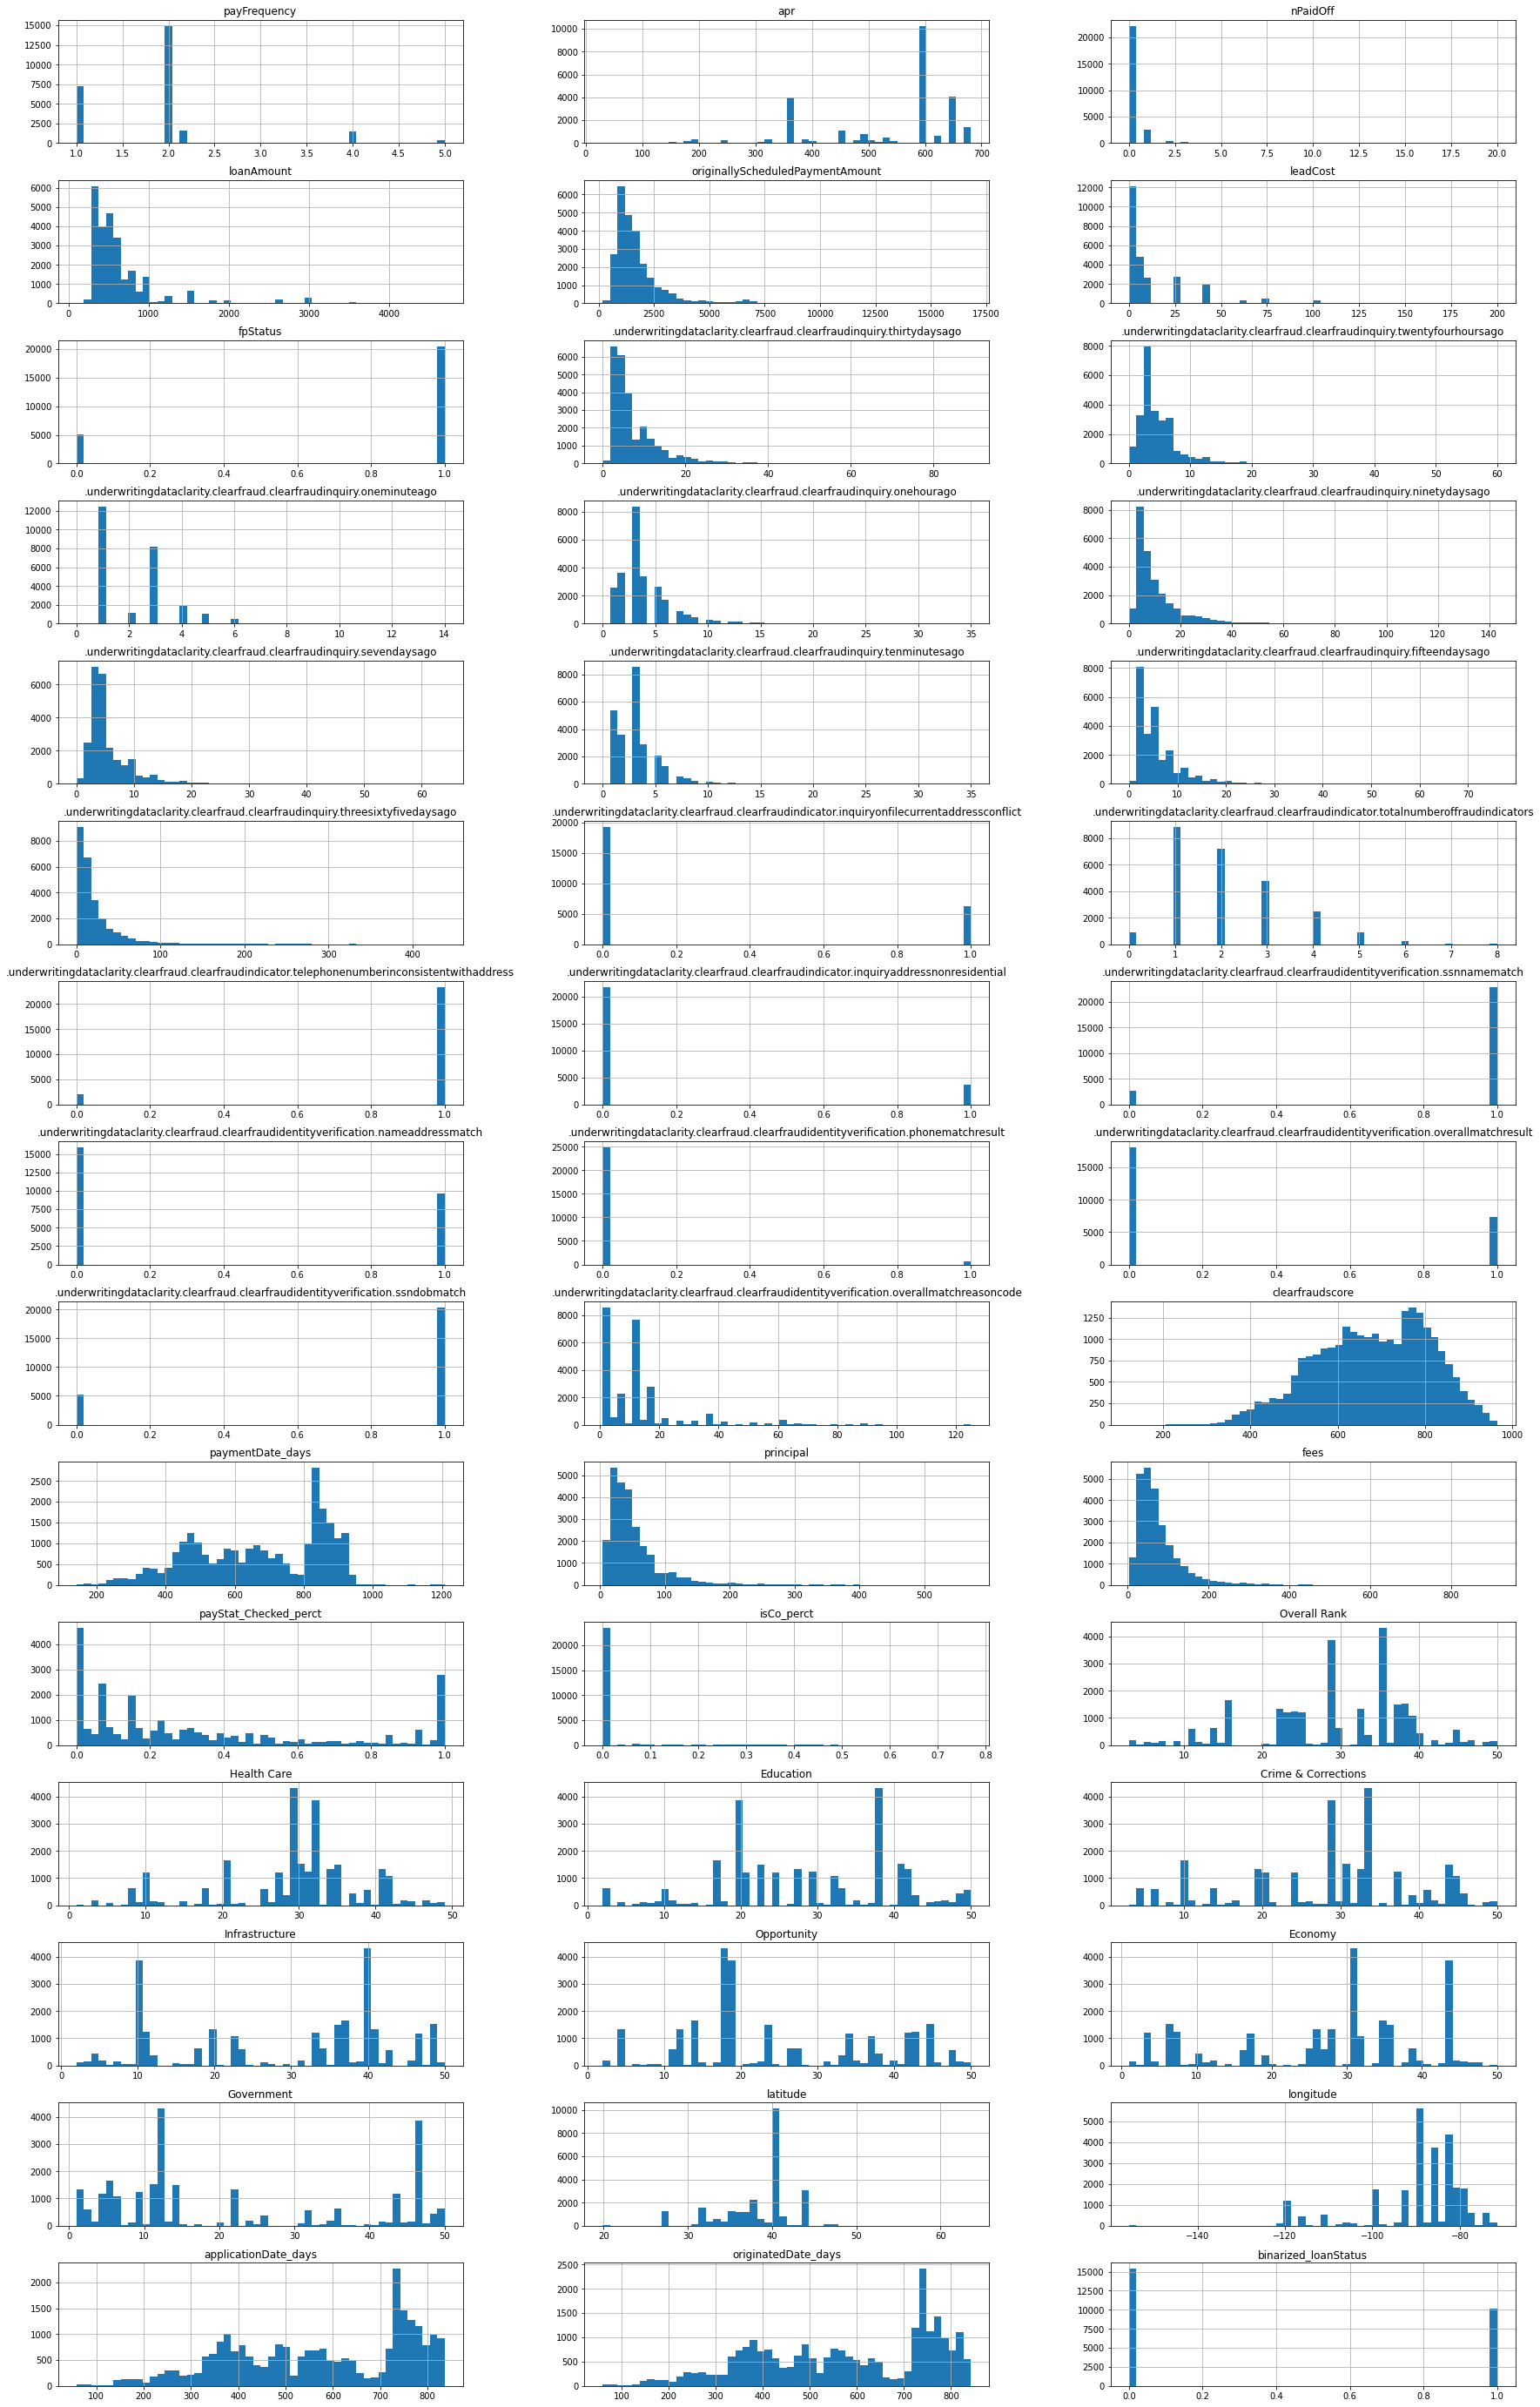

In [ ]:
loan_.select_dtypes(include=["float64", "int64"]).hist(bins=50, figsize=(30,50), layout=(15,3))
plt.show()

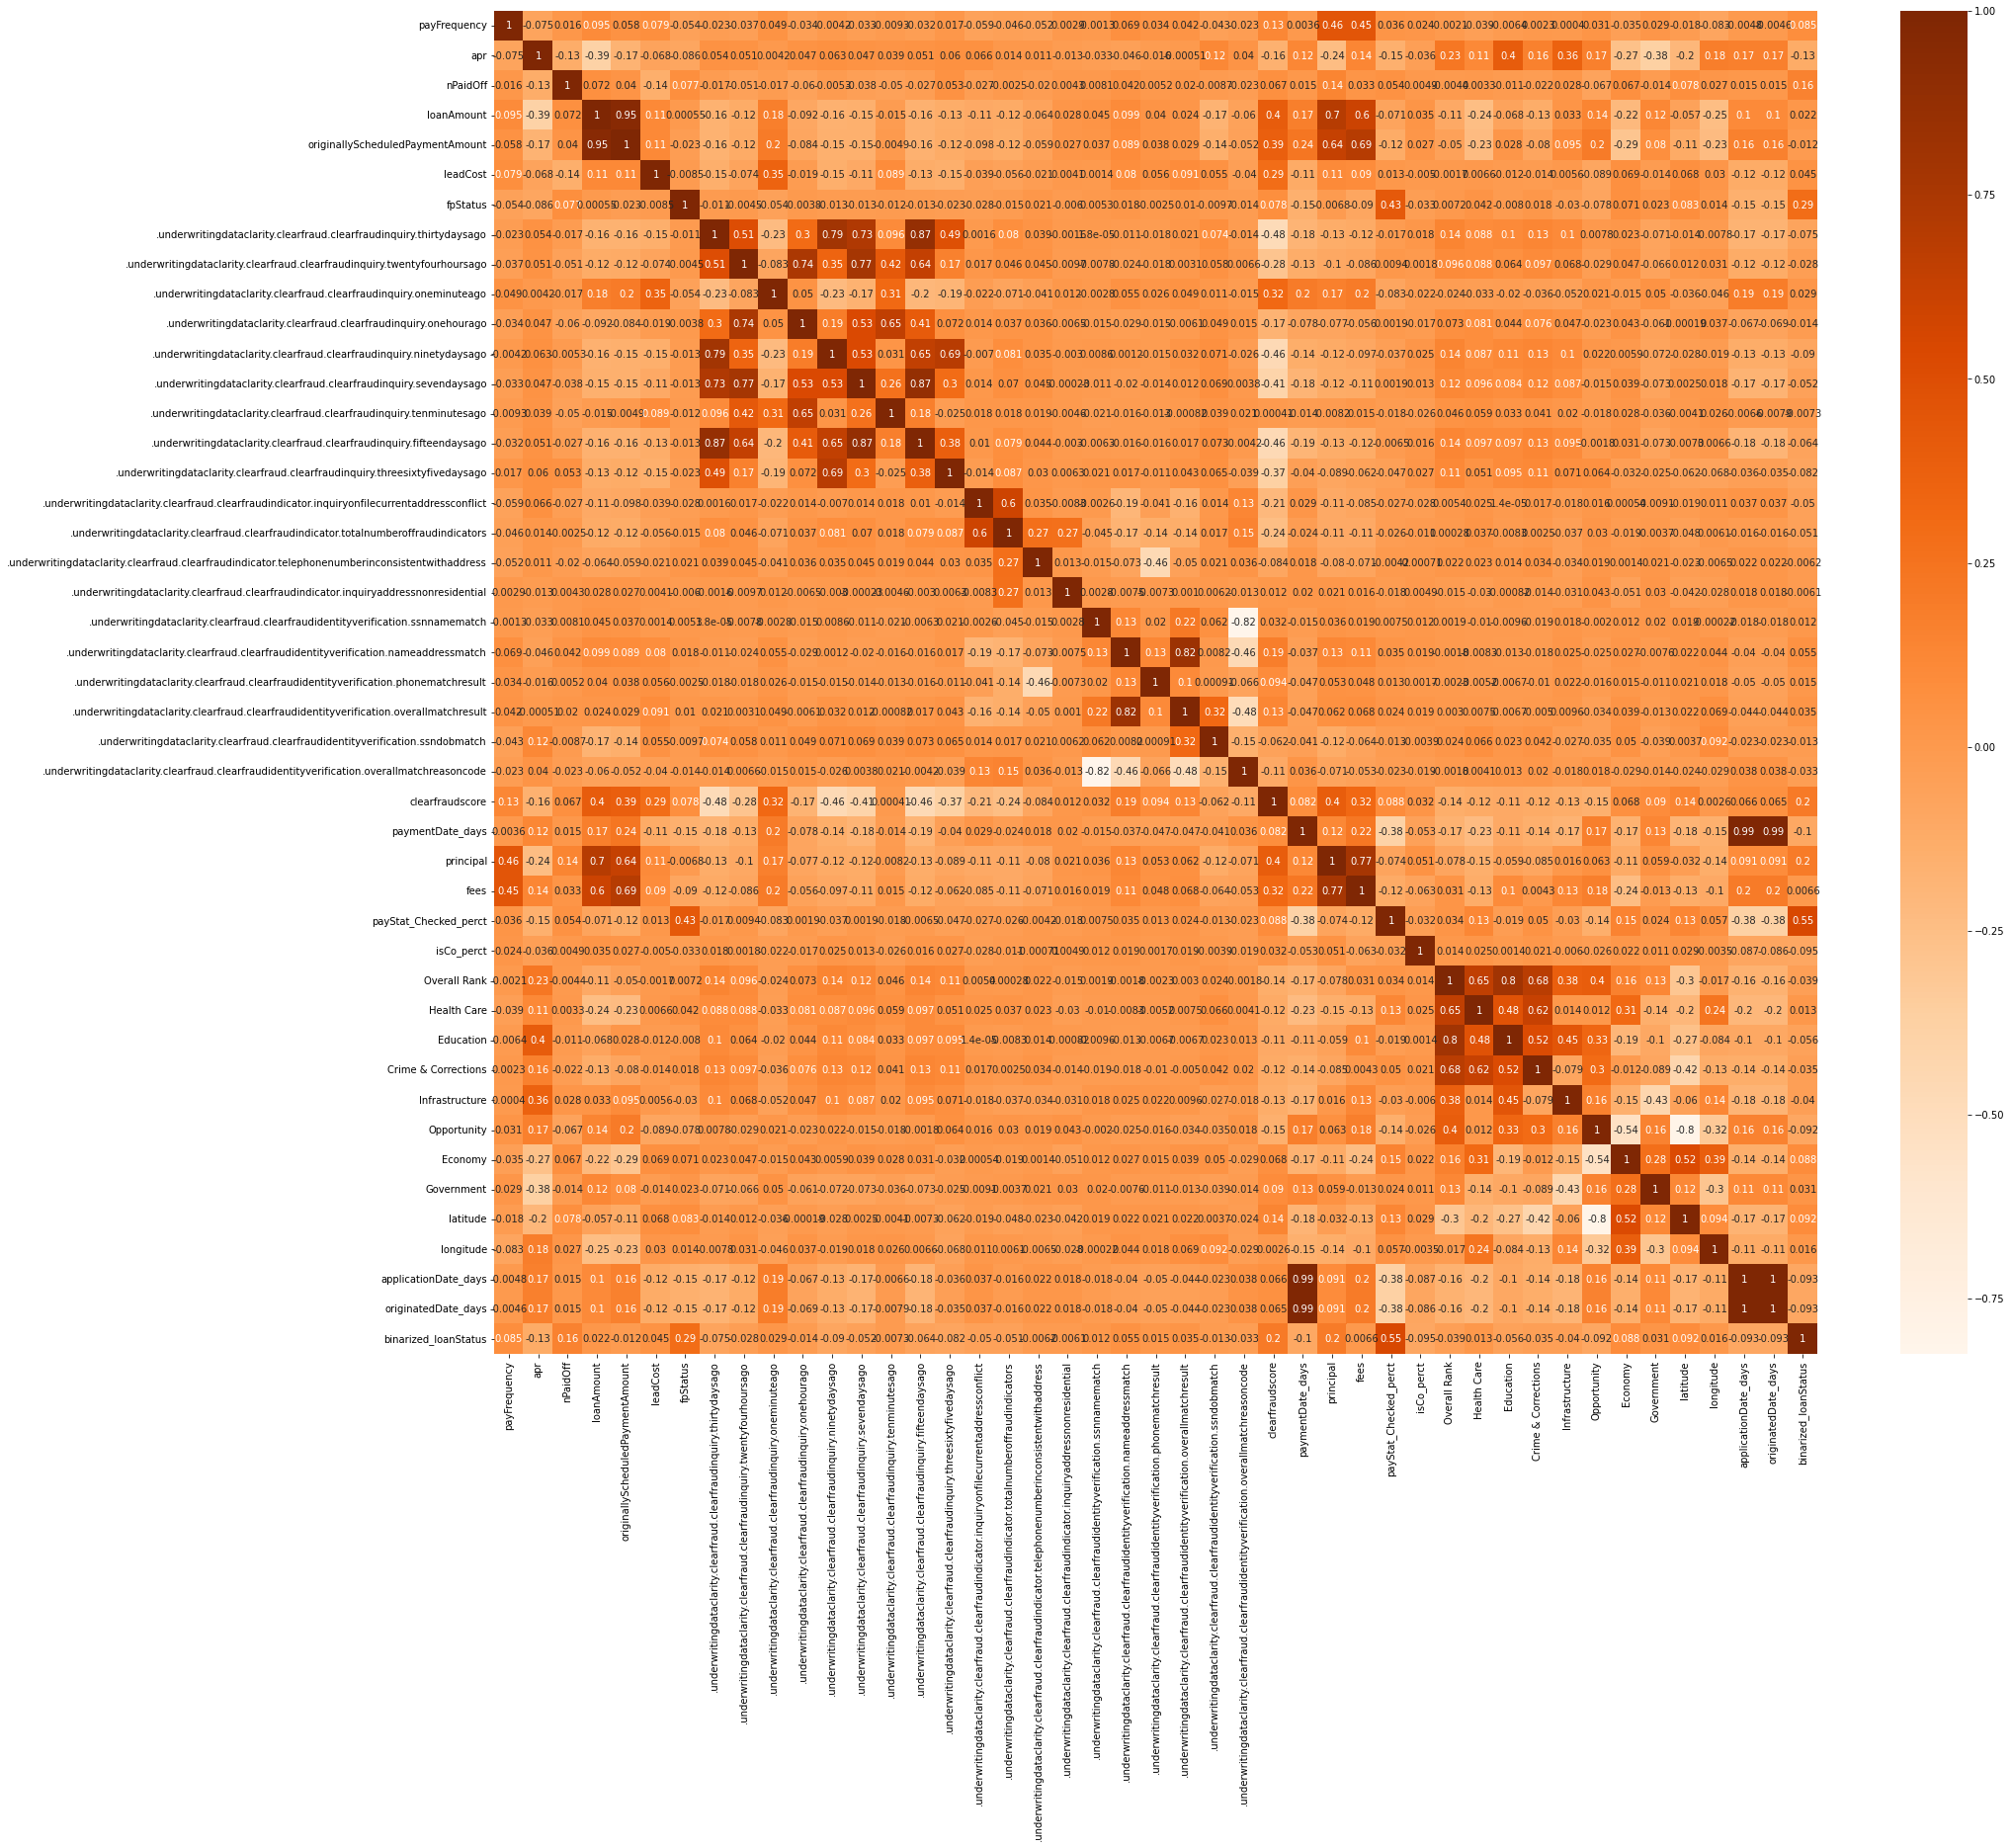

In [ ]:
corr_matrix = loan_.corr()
plt.figure(figsize=(30,25))
sns.heatmap(corr_matrix,annot=True,cmap="Oranges")

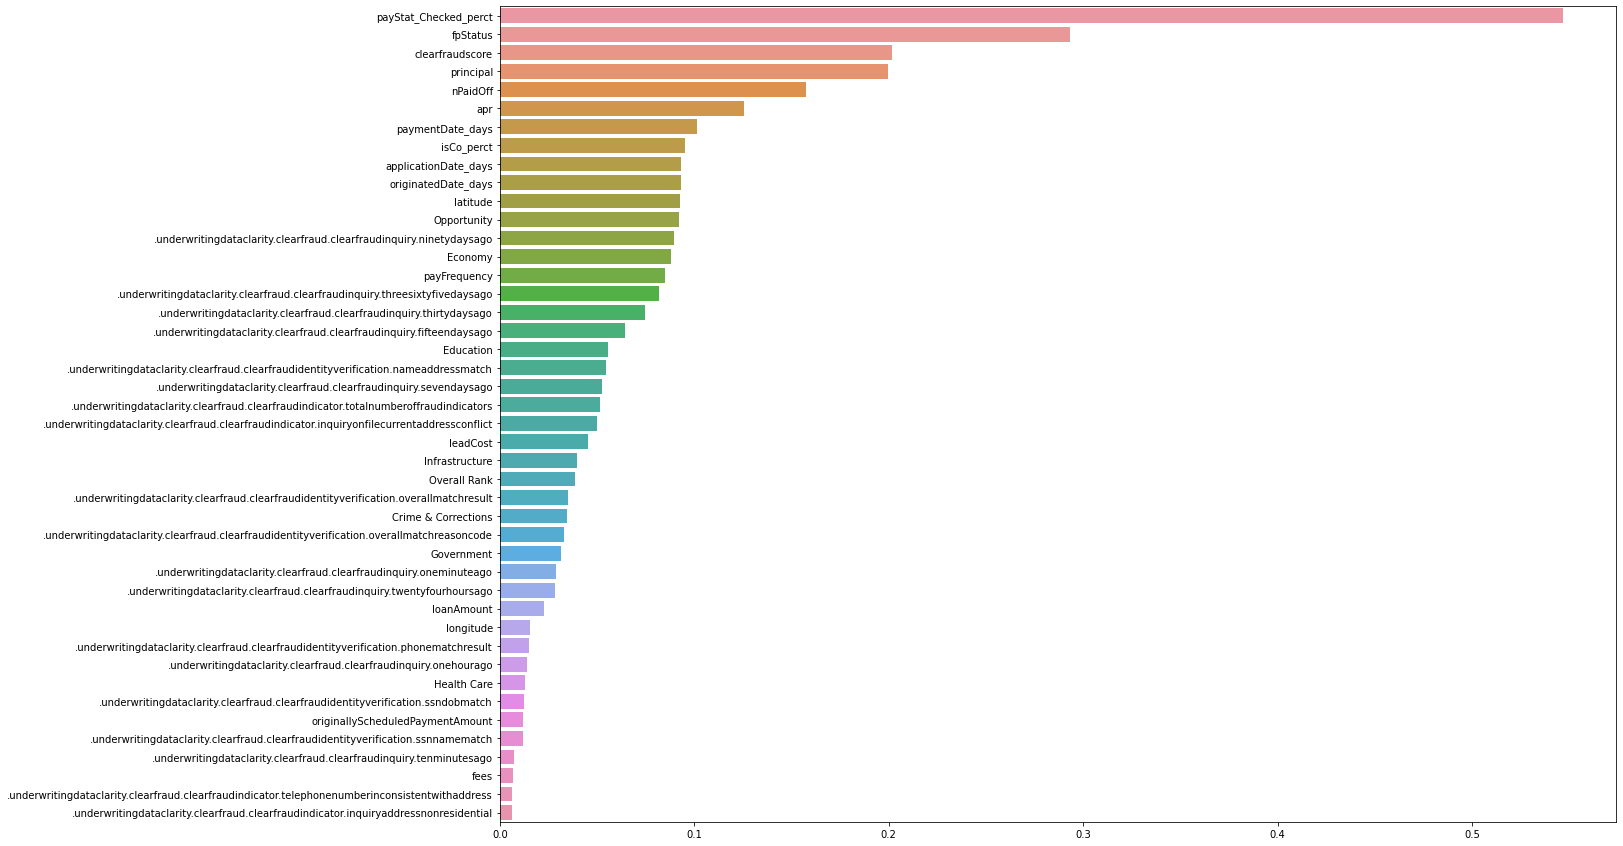

In [ ]:
corr = abs(corr_matrix.loc[:,"binarized_loanStatus"]).sort_values(ascending=False)
plt.figure(figsize = (20, 15))
sns.barplot(x=np.squeeze(pd.DataFrame(corr).values)[1:], y=pd.DataFrame(corr).index.tolist()[1:])

## Insights on Dataset
Below plots a few features that are inspired by Pearson's correlation, which is able to indicate linear relationships. These features are further supported by XGBoost's feature importance later on. Note that the insights gained here are based on linear relationships and are highly speculative. In reality, multiple factors are at play and there might be more complex, non-linear relationships. More experiments (e.g. hypothesis testing, causation investigation) should be done to verify these claims. However, it is important to come up with possible explanations because correlation does not imply causation[5]. 

[5] https://tylervigen.com/spurious-correlations

In [ ]:
#https://matplotlib.org/stable/gallery/color/named_colors.html
palette={0: "red", 1: "limegreen"}

def plot_histo(col, mode, binwidth=None):
  plt.figure(figsize=(20, 5))
  plot_df = loan.loc[:,[col, "binarized_loanStatus"]]
  try:
    print("corr =", corr_matrix.loc[col,"binarized_loanStatus"])
  except KeyError:
    pass
  if mode=="cat":
    binwidth = 0.4 if not binwidth else binwidth
    sns.displot(plot_df, x=col, hue="binarized_loanStatus", multiple="dodge", binwidth=binwidth, stat="density", common_norm=False, palette=palette)
  elif mode=="conti":
    binwidth = 0.05 if not binwidth else binwidth
    sns.displot(plot_df, x=col, hue="binarized_loanStatus", element="step", binwidth=binwidth, stat="density", common_norm=False, palette=palette)
  plt.show()

##### 1. Good loans normally start with a successful payment ("Checked")

corr = 0.29330899323250187


<Figure size 1440x360 with 0 Axes>

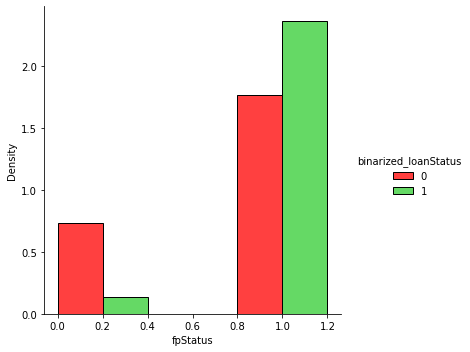

In [ ]:
plot_histo("fpStatus", mode="cat")

##### 2. "payStat_Checked_perct" refers to the percentage of scuccessful payments ("Checked") for a loan. The more the proportion of sucessful payments made, the more likely it is for the loan to be paid off at the end. 

corr = 0.5467377836435775


<Figure size 1440x360 with 0 Axes>

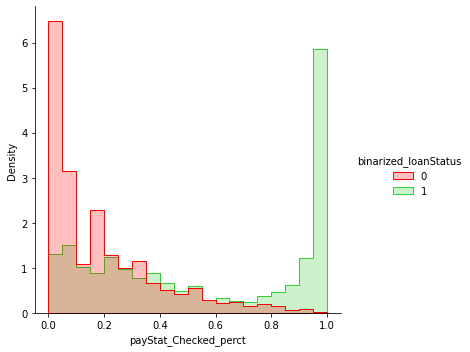

In [ ]:
plot_histo("payStat_Checked_perct", mode="conti")

##### 3. The larger the principal amount loaned, the more likely it is for the loan to be paid off. This seems a little counter-intuitive, but my guess would be that the borrower with larger funds are more likely to have larger capital gains.

corr = 0.02244571761373044


<Figure size 1440x360 with 0 Axes>

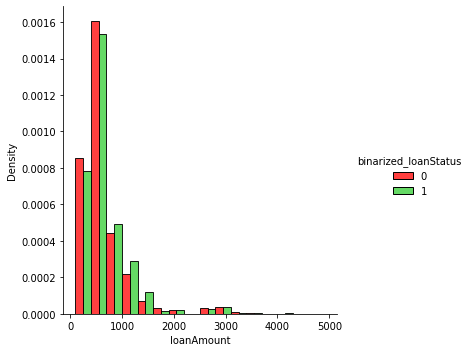

In [ ]:
plot_histo("loanAmount", mode="cat", binwidth=300)

##### 4. Following the reasoning in (3), a larger loan amount means that the borrower would need to pay a larger principal during repayments.

corr = 0.199633805641055


<Figure size 1440x360 with 0 Axes>

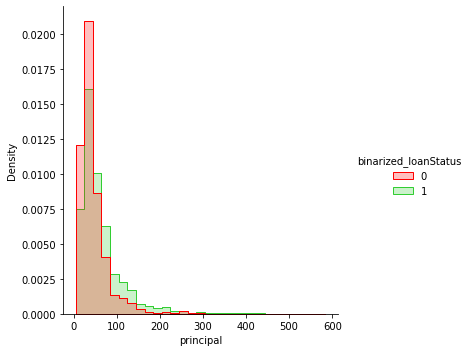

In [ ]:
plot_histo("principal", mode="conti", binwidth=20)

##### 5. A schedule of repayment that is too tight might lead to the borrower being illiquid. Note that "payFrequency" is in "weeks" unit, with a value of 1 meaning repayment is made weekly.

corr = 0.08494751936911611


<Figure size 1440x360 with 0 Axes>

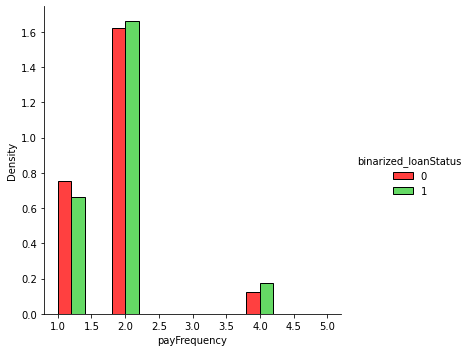

In [ ]:
plot_histo("payFrequency", mode="cat")

##### 6. Borrowers with a good track record are likely to remain so.


corr = 0.15760970636890692


<Figure size 1440x360 with 0 Axes>

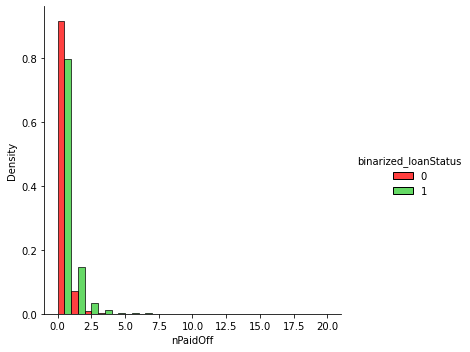

In [ ]:
plot_histo("nPaidOff", mode="cat", binwidth=1)

##### 7. More loans ended up as bad loans close to the beginning of year 2017 compared to other years within the timespan 01/2015 to 03/2017. Or maybe it's the waiting duration from application to fund transfer.

corr = -0.09299498656966793


<Figure size 1440x360 with 0 Axes>

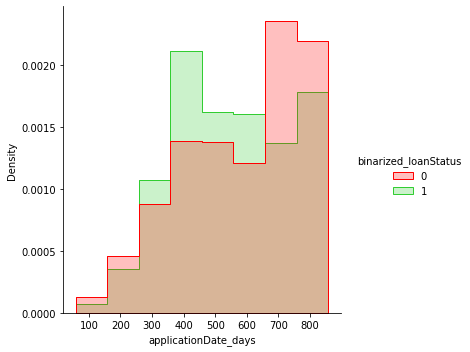

In [ ]:
plot_histo("applicationDate_days", mode="conti", binwidth=100)

##### 8. Bank verification is important, probably to prevent fraud.

<Figure size 1440x360 with 0 Axes>

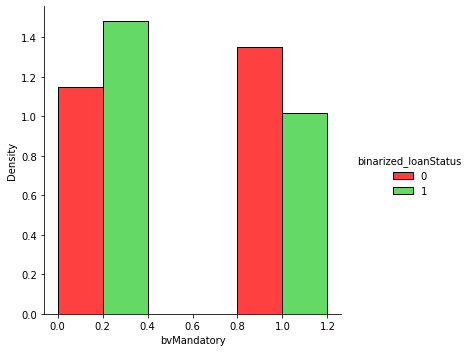

In [ ]:
loan.loc[:,"bvMandatory"] = (loan.loc[:,"leadType"] == "bvMandatory").apply(lambda x : 1 if x else 0)
plot_histo("bvMandatory", mode="cat", binwidth=0.4)
loan = loan.drop(columns="bvMandatory")

##### 9. A high cost of loan increases the likelihood of default.

corr = -0.12560350988713725


<Figure size 1440x360 with 0 Axes>

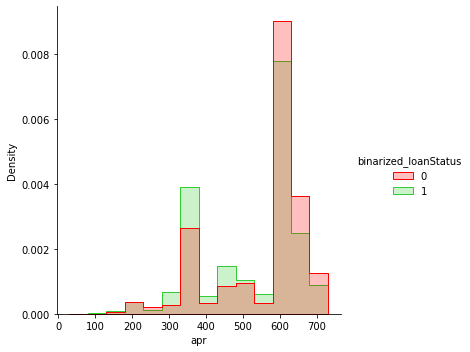

In [ ]:
plot_histo("apr", mode="conti", binwidth=50)

##### 10. Fraud score provided by clarity. Higher score suggests lower default probability.

corr = 0.20184228249504413


<Figure size 1440x360 with 0 Axes>

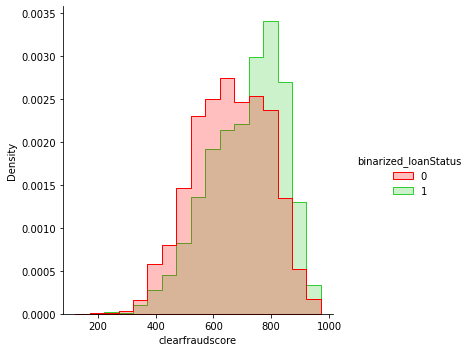

In [ ]:
plot_histo("clearfraudscore", mode="conti", binwidth=50)

## Build Train/Test Set

In [ ]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25577 entries, 0 to 25576
Data columns (total 47 columns):
 #   Column                                                                                          Non-Null Count  Dtype  
---  ------                                                                                          --------------  -----  
 0   payFrequency                                                                                    25577 non-null  float64
 1   apr                                                                                             25577 non-null  float64
 2   nPaidOff                                                                                        25577 non-null  float64
 3   loanStatus                                                                                      25577 non-null  object 
 4   loanAmount                                                                                      25577 non-null  float64
 5   originallyS

In [ ]:
train_set, test_set = train_test_split(loan, test_size=0.2, random_state=42)
print(train_set.shape, test_set.shape)

(20461, 47) (5116, 47)


In [ ]:
label = ["loanStatus", "binarized_loanStatus"]
x_train_notsfm = train_set.drop(columns=label)
y_train = train_set.loc[:,label[1]].copy()
x_test_notsfm = test_set.drop(columns=label)
y_test = test_set.loc[:,label[1]].copy()

cat_attribs = ["leadType"]
num_attribs = loan.columns.tolist()
num_attribs.remove(cat_attribs[0])
num_attribs.remove(label[0])
num_attribs.remove(label[1])

ds_tsfm = ColumnTransformer(
    [("num", StandardScaler(), num_attribs),
     ("cat", OneHotEncoder(), cat_attribs)],
)

x_train = ds_tsfm.fit_transform(x_train_notsfm)
x_test = ds_tsfm.transform(x_test_notsfm) #use train set statistics
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(20461, 54) (20461,)
(5116, 54) (5116,)


## Hyperparameter Search & Training

In [47]:
#eval_metric in https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
#logloss = negative log likelihood = multiclass cross-entropy
xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', eval_metric="logloss", random_state=42)

#ref (whichever is tighter): 
#[1] the kagglebook by Konrad, interview of Alberto Danese
#[2] https://twitter.com/tunguz/status/1572642449302106112
xgb_params_distribs = {
  "n_estimators": randint(low=50,high=700),
  "learning_rate": loguniform(0.01, 1.0),
  "min_child_weight": randint(low=1,high=10),
  "max_depth": randint(low=3,high=20),
  "subsample": uniform(loc=0.4,scale=1.0-0.4),
  "colsample_bytree": uniform(loc=0.3,scale=1.0-0.3),
  "reg_lambda": loguniform(1e-3, 10.0),
  "reg_alpha": loguniform(1e-3, 10.0),
  "gamma": loguniform(1e-9, 0.1),
}

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
xgb_rand_cv = RandomizedSearchCV(estimator=xgb_clf, 
                                   param_distributions=xgb_params_distribs, 
                                   n_iter=20, cv=5, verbose=2, #highest verbose
                                   random_state=42, n_jobs=-1)
xgb_rand_cv.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(eval_metric='logloss',
                                           random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff53fc99a50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff53f30c750>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_froze...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff53e95b890>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff53fb38a50>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff53fc99950>,
                                        'subsample': <scipy.stats._dist

In [48]:
pd.set_option('display.max_colwidth', None)
cv_results = pd.DataFrame(xgb_rand_cv.cv_results_).sort_values("rank_test_score")
cv_results.iloc[:,4:]

,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.736309,0.0,0.0134,7,3,596,0.077421,0.003009,0.827947,"{'colsample_bytree': 0.7363086887792905, 'gamma': 4.4379683310623423e-07, 'learning_rate': 0.013400367243354798, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 596, 'reg_alpha': 0.07742116473996243, 'reg_lambda': 0.003008686821445843, 'subsample': 0.827946872333797}",0.919863,0.917400,0.919355,0.919110,0.919844,0.919114,0.000904,1
13,0.918296,0.0,0.017546,9,1,434,0.008161,0.051101,0.890809,"{'colsample_bytree': 0.9182961812432078, 'gamma': 3.933328039216057e-07, 'learning_rate': 0.017545910486566178, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 434, 'reg_alpha': 0.008160948743089919, 'reg_lambda': 0.051101206564971614, 'subsample': 0.8908088595534959}",0.921329,0.916422,0.914223,0.921554,0.914467,0.917599,0.003230,2
3,0.776215,0.000004,0.01063,16,2,395,0.002459,0.545673,0.664091,"{'colsample_bytree': 0.7762152770114458, 'gamma': 4.017852745189941e-06, 'learning_rate': 0.010629918194937634, 'max_depth': 16, 'min_child_weight': 2, 'n_estimators': 395, 'reg_alpha': 0.0024586032763280045, 'reg_lambda': 0.5456725485601474, 'subsample': 0.6640914962437607}",0.918397,0.916911,0.912268,0.919110,0.915689,0.916475,0.002414,3
14,0.902511,0.0,0.105074,11,5,274,0.003016,0.022411,0.965746,"{'colsample_bytree': 0.9025114082794403, 'gamma': 1.1366245816554799e-09, 'learning_rate': 0.10507384024181395, 'max_depth': 11, 'min_child_weight': 5, 'n_estimators': 274, 'reg_alpha': 0.003016209262796776, 'reg_lambda': 0.022410971619109505, 'subsample': 0.9657458223475115}",0.918153,0.916911,0.912023,0.916667,0.916911,0.916133,0.002120,4
16,0.510615,0.0,0.011852,19,2,691,0.044071,0.001356,0.607043,"{'colsample_bytree': 0.5106148168717387, 'gamma': 1.8998703060878187e-07, 'learning_rate': 0.011851515660043107, 'max_depth': 19, 'min_child_weight': 2, 'n_estimators': 691, 'reg_alpha': 0.044070507657925015, 'reg_lambda': 0.0013558227959926893, 'subsample': 0.6070427488160098}",0.919130,0.915200,0.914956,0.915934,0.913245,0.915693,0.001931,5
2,0.66733,0.000003,0.038235,12,3,616,8.56887,0.073629,0.915964,"{'colsample_bytree': 0.6673295021425665, 'gamma': 2.8546978577971797e-06, 'learning_rate': 0.03823475224675185, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 616, 'reg_alpha': 8.568869785189001, 'reg_lambda': 0.07362945281639215, 'subsample': 0.9159642440417923}",0.914488,0.913490,0.915689,0.914956,0.917644,0.915253,0.001392,6
7,0.724924,0.0,0.039133,15,1,570,1.22738,0.006235,0.403313,"{'colsample_bytree': 0.7249239733806793, 'gamma': 1.6143342323367594e-07, 'learning_rate': 0.039133348581043725, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 570, 'reg_alpha': 1.2273800987852959, 'reg_lambda': 0.006235377135673155, 'subsample': 0.4033132702741615}",0.917664,0.912023,0.913001,0.917155,0.915200,0.915009,0.002220,7
11,0.322,0.000123,0.042532,6,5,456,0.261619,0.144333,0.521837,"{'colsample_bytree': 0.322000429980714, 'gamma': 0.0001233909449396553, 'learning_rate': 0.04253162363790869, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 456, 'reg_alpha': 0.26161914205169595, 'reg_lambda': 0.14433257678806027, 'subsample': 0.5218367348408617}",0.917420,0.912757,0.914956,0.913490,0.915934,0.914911,0.001674,8
17,0.744046,0.000279,0.115311,8,7,488,1.112957,0.008924,0.83693,"{'colsample_bytree': 0.7440459412909546, 'gamma': 0.00027902531843310374, 'learning_rate': 0.11531058266441355, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 488, 'reg_alpha': 1.1129571947045998, 'reg_lambda': 0.008923807143379777, 'subsample': 0.8369298091671158}",0.916931,0.909335,0.916911,0.913245,0.915200,0.914325,0.002839,9
8,0.870823,0.000452,0.287088,3,5,539,0.027156,0.002907,0.9178

In [49]:
xgb_rand_cv.best_params_

{'colsample_bytree': 0.7363086887792905,
 'gamma': 4.4379683310623423e-07,
 'learning_rate': 0.013400367243354798,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 596,
 'reg_alpha': 0.07742116473996243,
 'reg_lambda': 0.003008686821445843,
 'subsample': 0.827946872333797}

In [50]:
best_model = xgb_rand_cv.best_estimator_
best_model

XGBClassifier(colsample_bytree=0.7363086887792905, eval_metric='logloss',
              gamma=4.4379683310623423e-07, learning_rate=0.013400367243354798,
              max_depth=7, min_child_weight=3, n_estimators=596,
              random_state=42, reg_alpha=0.07742116473996243,
              reg_lambda=0.003008686821445843, subsample=0.827946872333797)

## Best Model

In [ ]:
"""
xgb_clf = xgboost.XGBClassifier(colsample_bytree=0.7363086887792905, eval_metric='logloss',
              gamma=4.4379683310623423e-07, learning_rate=0.013400367243354798,
              max_depth=7, min_child_weight=3, n_estimators=596,
              random_state=42, reg_alpha=0.07742116473996243,
              reg_lambda=0.003008686821445843, subsample=0.827946872333797)
xgb_clf.fit(x_train, y_train)
best_model = xgb_clf
"""

## Check Overfitting
Train-validation score gap is acceptable, overfitting issue is not serious.

In [51]:
best_params = {'colsample_bytree': [0.7363086887792905],
 'gamma': [4.4379683310623423e-07],
 'learning_rate': [0.013400367243354798],
 'max_depth': [7],
 'min_child_weight': [3],
 'n_estimators': [596],
 'reg_alpha': [0.07742116473996243],
 'reg_lambda': [0.003008686821445843],
 'subsample': [0.827946872333797]}

xgb_rand_cv = RandomizedSearchCV(estimator=xgb_clf, 
                                   param_distributions=best_params, 
                                   n_iter=1, cv=5, verbose=2, #highest verbose
                                   random_state=42, n_jobs=-1, return_train_score=True)
xgb_rand_cv.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(eval_metric='logloss',
                                           random_state=42),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7363086887792905],
                                        'gamma': [4.4379683310623423e-07],
                                        'learning_rate': [0.013400367243354798],
                                        'max_depth': [7],
                                        'min_child_weight': [3],
                                        'n_estimators': [596],
                                        'reg_alpha': [0.07742116473996243],
                                        'reg_lambda': [0.003008686821445843],
                                        'subsample': [0.827946872333797]},
                   random_state=42, return_train_score=True, verbose=2)

In [52]:
cv_results = pd.DataFrame(xgb_rand_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,param_max_depth,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,58.317971,9.466649,0.316943,0.109337,0.827947,0.003009,0.077421,596,3,7,...,0.919114,0.000904,1,0.957539,0.957664,0.957603,0.958153,0.959191,0.95803,0.00062


In [53]:
y_train_pred_proba = xgb_rand_cv.predict_proba(x_train)
print("train_loss\t\t = ", metrics.log_loss(y_train, y_train_pred_proba))
print("cv_mean_train_score\t = ", cv_results.loc[0,"mean_train_score"])
print("cv_mean_test_score\t = ", cv_results.loc[0,"mean_test_score"])

train_loss		 =  0.14262127744908404
cv_mean_train_score	 =  0.9580299045647344
cv_mean_test_score	 =  0.9191143761886099


## Feature Importance (XGBoost)

Desicive features can be grouped into the following categories:

* Payment history and behavior
** e.g. first payment status (fpStatus), percentage of successful payments 
(payStat_Checked_perct), percentage of payments that is comprised of a custom made collection plan (isCo_perct), loans paid off in the past (nPaidoff) etc.
* Loan repayment scheme
** e.g. average amount to pay for each repayment (principal), repayment frequency (payFrequency), total amount loaned (loanAmount), cost of loan (apr), interest (fees)
* Loan time and duration
** e.g. applicationDate, originatedDate
* Lead type
** e.g. byMandatory, lead, california, prescreen
* Risk of fraud
** e.g. clearfraudscore

Other observations:

* State features (e.g. Crime & Corrections, Overall Rank, Education) have relatively more importance than underwriting report details
* Lead types that are important are byMandatory, lead, california, prescreen and organic. Other lead types (e.g. promotional loans) have relatively little importance.

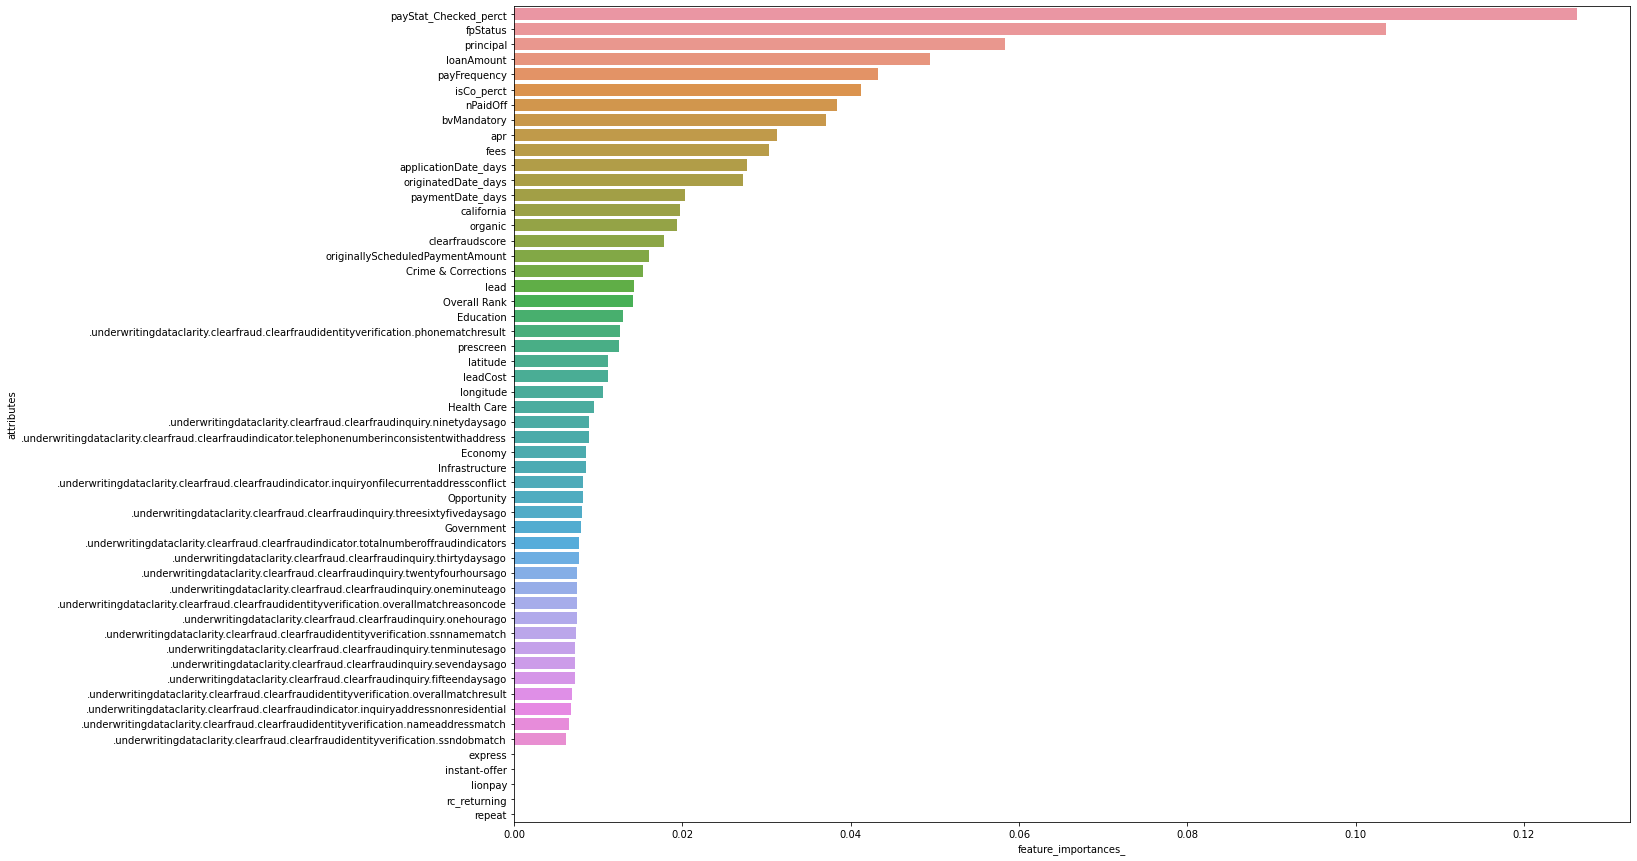

In [54]:
cat_encoder = ds_tsfm.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs

feat_importance = pd.DataFrame({"feature_importances_": best_model.feature_importances_,
                                "attributes": attributes})
feat_importance = feat_importance.sort_values("feature_importances_", ascending=False)

plt.figure(figsize = (20, 15))
sns.barplot(x = feat_importance.loc[:,"feature_importances_"], 
            y = feat_importance.loc[:,"attributes"])
plt.show()

## Testing

In loan investment, false positives are more costly than false negatives. Therefore, a model with a highter precision would be more useful.

In [55]:
y_test_pred = best_model.predict(x_test)
y_test_pred_proba = best_model.predict_proba(x_test)

test_loss	=  0.19986239104651898
Acc		=  91.32 %
Precison	=  92.48 %
Recall		=  84.72 %
F1		=  88.43 %
ROC_AUC		=  0.9014




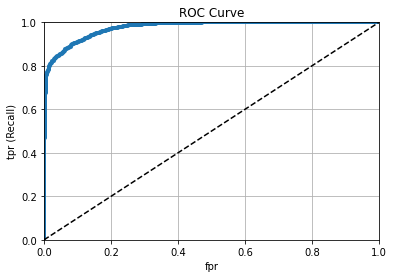

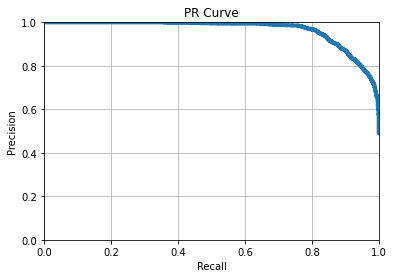

In [56]:
test_loss = metrics.log_loss(y_test, y_test_pred_proba)
accuracy = metrics.accuracy_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
f1 = metrics.f1_score(y_test, y_test_pred)
roc_auc = metrics.roc_auc_score(y_test, y_test_pred)

print("test_loss\t= ", test_loss)
print("Acc\t\t= ", round(accuracy * 100, 2), "%")
print("Precison\t= ", round(precision * 100, 2), "%")
print("Recall\t\t= ", round(recall * 100, 2), "%")
print("F1\t\t= ", round(f1 * 100, 2), "%")
print("ROC_AUC\t\t= ", round(roc_auc, 4)) #perfect = 1
print("\n")

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_proba[:,1])
plt.plot(fpr, tpr, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1]) 
plt.title("ROC Curve")                                   
plt.xlabel("fpr") 
plt.ylabel("tpr (Recall)")    
plt.grid(True)                                            
plt.show()

precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_pred_proba[:,1])
plt.plot(recalls, precisions, linewidth=4)
plt.axis([0, 1, 0, 1])
plt.title("PR Curve")  
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

#train_loss = 0.14262127744908404

## Error Analysis

Analyze what subcategories do the wrong predictions belong to.

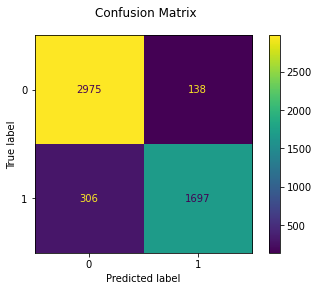

In [57]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()
#~40% positive

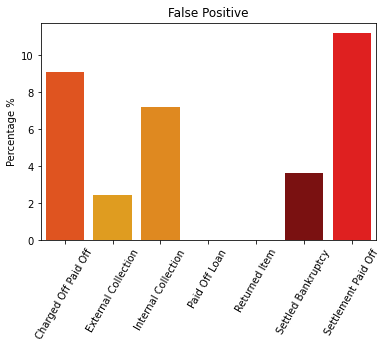

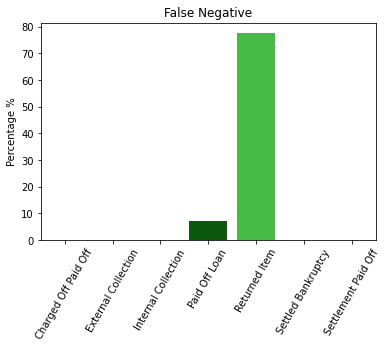

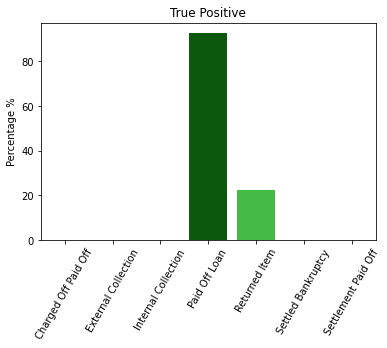

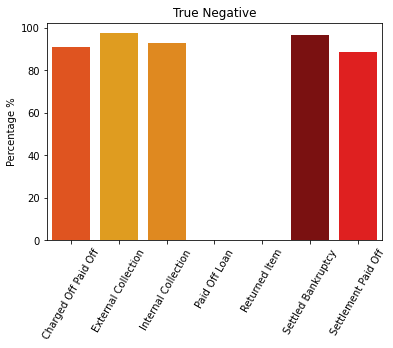

In [58]:
fp = test_set.iloc[np.where(y_test_pred - y_test ==  1)[0],:].loc[:,"loanStatus"].value_counts()
fn = test_set.iloc[np.where(y_test_pred - y_test == -1)[0],:].loc[:,"loanStatus"].value_counts()
tp = test_set.iloc[np.where(np.logical_and(y_test_pred == y_test, y_test == 1))[0],:].loc[:,"loanStatus"].value_counts()
tn = test_set.iloc[np.where(np.logical_and(y_test_pred == y_test, y_test == 0))[0],:].loc[:,"loanStatus"].value_counts()

df = pd.DataFrame({"False Positive":fp, "False Negative":fn, "True Positive":tp, "True Negative":tn})
df.loc[:,"loanStatus_sum"] = df.sum(axis="columns")
df = df.div(df.loc[:,"loanStatus_sum"], axis="index")*100

palette = {"Paid Off Loan":"darkgreen", "Returned Item":"limegreen",
           "External Collection":"orange", "Internal Collection":"darkorange", "Settlement Paid Off":"red", "Settled Bankruptcy":"darkred", "Charged Off Paid Off":"orangered"}

for i in range(4):
  plt.xticks(rotation=60)
  plt.title(df.columns[i])
  ax = sns.barplot(x=df.index, y=df.iloc[:,i], palette=palette)
  ax.set(ylabel="Percentage %")
  plt.show()

## Conclusions 
* Engineered payment statistics (e.g. percentage of successful payments, percentage of payments that is comprised of a custom-made collection plan) are useful to predict loan repayment. 
* Other than fraud score, the other details of an underwriting report are relatively not important.
* Using additional information to characterize a state can be helpful. 
* A good track record of loan repayment is the most decisive factor for identifying profiting loans.
* Offering more lenient repayment schemes, e.g. smaller repayment amounts and lower repayment frequency, is helpful for reducing the burden of the borrower, leading to lower risk of default.
* Careful underwriting procedures, such as performing bank verifications, is conducive to spotting frauds.

Time Spent: 5 days, 3~4 hrs each day

## Future Works
* Preprocess skewed (long-tail) distributions, e.g. by using log transformation
* Perform hypothesis testing on feature distributions in "Insights on Dataset"
* Use dimenionality reduciton techniques and decision tree models to gain more insights on the dataset
* Perform automatic feature selection using techniques like recursive feature elimination with cross-validation (RFECV)
